C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

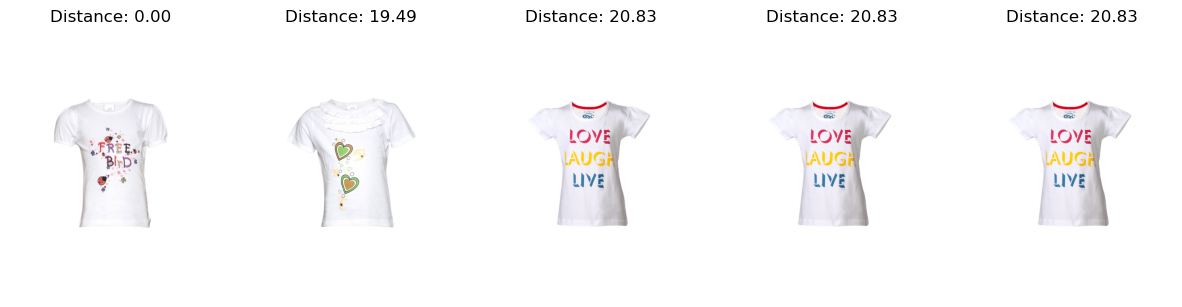

Total time taken: 3.7636 seconds


In [1]:
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt
import cv2
import time
from tkinter import Tk, filedialog
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

# Step 1: Load Pre-trained Model
# ============================================
# We use ResNet50, a pre-trained model on the ImageNet dataset, as our feature extractor.
# The classification layers are removed, and we only use the output of the global average pooling (avg_pool) layer.
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


# Step 2: Feature Extraction
# ============================================
# Function to preprocess an image, extract its features using the ResNet50 model, and return a flattened feature vector.
def extract_features(img_path):
    """
    Extracts feature vector from an image.

    Parameters:
        img_path (str): Path to the input image.
    
    Returns:
        np.ndarray: Flattened feature vector of the image.
    """
    # Load the image and resize to 224x224 (required by ResNet50).
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a NumPy array and preprocess for ResNet50.
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    # Predict features using the ResNet50 model.
    features = model.predict(img_data)
    
    # Return the flattened feature vector.
    return features.flatten()


# Function to process all images in a folder and extract their features.
def extract_features_from_folder(folder_path):
    """
    Extracts features for all images in a folder.

    Parameters:
        folder_path (str): Path to the folder containing images.
    
    Returns:
        np.ndarray: Array of feature vectors for all images.
    """
    feature_list = []
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        features = extract_features(img_path)
        feature_list.append(features)
    return np.array(feature_list)


# Step 3: Dimensionality Reduction
# ============================================
# Perform PCA to reduce the dimensionality of the extracted features.

# Standardize the feature data to have zero mean and unit variance.
scaler = StandardScaler()

# Extract features from the image dataset folder.
image_features = extract_features_from_folder(
    'C:\\Users\\hp\\Downloads\\archive (5)\\data\\Apparel\\Girls\\Images\\images_with_product_ids'
)
scaled_features = scaler.fit_transform(image_features)

# Apply PCA to reduce feature dimensions to 50.
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(scaled_features)


# Step 4: Clustering
# ============================================
# Use K-Means clustering to group similar images into clusters.

kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(reduced_features)


# Step 5: Build a KD-Tree for Fast Nearest Neighbor Search
# ============================================
# KD-Tree is built using the reduced features to allow fast nearest-neighbor searches.

kd_tree = KDTree(reduced_features, leaf_size=30)

# Function to find the top K most similar images for a given query feature vector.
def find_similar_images(query_feature, k=5):
    """
    Finds the top K most similar images using KD-Tree.

    Parameters:
        query_feature (np.ndarray): Feature vector of the query image.
        k (int): Number of similar images to retrieve.
    
    Returns:
        Tuple[np.ndarray, np.ndarray]: Indices and distances of the K nearest neighbors.
    """
    dist, ind = kd_tree.query(query_feature.reshape(1, -1), k=k)
    return ind[0], dist[0]


# Step 6: Display Similar Images
# ============================================
# Define functions to map image indices to filenames and display results.

def get_image_filenames(data_directory):
    """
    Maps image indices to filenames.

    Parameters:
        data_directory (str): Path to the folder containing images.
    
    Returns:
        List[str]: Sorted list of image filenames.
    """
    filenames = sorted([f for f in os.listdir(data_directory) if f.endswith('.jpg')])
    return filenames

def display_similar_images(indices, distances, data_directory, filenames):
    """
    Displays the similar images based on the indices returned by the KD-Tree.

    Parameters:
        indices (np.ndarray): Indices of the similar images.
        distances (np.ndarray): Similarity distances.
        data_directory (str): Path to the folder containing images.
        filenames (List[str]): List of filenames.
    """
    plt.figure(figsize=(15, 5))
    for i, (index, distance) in enumerate(zip(indices, distances)):
        # Retrieve image path and check bounds.
        if index < len(filenames):
            img_path = os.path.join(data_directory, filenames[index])
        else:
            print(f"Warning: Index {index} out of range.")
            continue
        
        # Load and display the image.
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, len(indices), i + 1)
            plt.imshow(img)
            plt.title(f"Distance: {distance:.2f}")
            plt.axis('off')
        else:
            print(f"Warning: Image at {img_path} could not be loaded.")
    plt.show()


# Step 7: Process Query Image and Find Similar Images
# ============================================
# This function allows the user to select a query image and find its similar images.

def process_query_image(k=5, data_directory="path_to_images"):
    """
    Processes a query image to find and display similar images.

    Parameters:
        k (int): Number of similar images to retrieve.
        data_directory (str): Path to the folder containing images.
    """
    # Open file dialog for user to select a query image.
    root = Tk()
    root.withdraw()
    query_img_path = filedialog.askopenfilename(
        title="Select Query Image",
        filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")]
    )
    root.destroy()

    if not query_img_path:
        print("No image selected. Exiting.")
        return

    print(f"Selected query image: {query_img_path}")
    
    # Extract features, standardize, and reduce dimensions.
    start_time = time.time()
    query_features = extract_features(query_img_path)
    query_features_scaled = scaler.transform([query_features])
    query_features_reduced = pca.transform(query_features_scaled)
    
    # Find similar images using KD-Tree.
    indices, distances = find_similar_images(query_features_reduced[0], k)
    
    # Retrieve filenames and display results.
    filenames = get_image_filenames(data_directory)
    display_similar_images(indices, distances, data_directory, filenames)
    
    total_time = time.time() - start_time
    print(f"Total time taken: {total_time:.4f} seconds")


# Example Usage
data_directory = "C:\\Users\\hp\\Downloads\\archive (5)\\data\\Apparel\\Girls\\Images\\images_with_product_ids"
process_query_image(k=5, data_directory=data_directory)


In [2]:
import os
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Step 1: Load Pre-trained ResNet50 Model
# ============================================
# ResNet50 is used as a feature extractor. The classification layers are removed, 
# and we use the output of the global average pooling ('avg_pool') layer.
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


# Step 2: Define Feature Extraction Function
# ============================================
# A utility function to extract a feature vector from an input image.

def extract_features(img_path):
    """
    Extracts feature vector from an image using ResNet50.

    Parameters:
        img_path (str): Path to the input image.
    
    Returns:
        np.ndarray: Flattened feature vector of the image.
    """
    # Load the image and resize it to 224x224 pixels (required by ResNet50).
    img = image.load_img(img_path, target_size=(224, 224))
    
    # Convert the image to a NumPy array and preprocess it for ResNet50.
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    
    # Extract features using the ResNet50 model.
    features = model.predict(img_data)
    
    # Return the flattened feature vector.
    return features.flatten()


# Step 3: Dataset Preparation and Feature Extraction
# ============================================
# Define the path to the image dataset and extract features from all images.

# Path to the folder containing the images
data_directory = "C:\\Users\\hp\\Downloads\\archive (5)\\data\\Apparel\\Girls\\Images\\images_with_product_ids"

# Get the list of all image file paths in the directory
image_paths = [os.path.join(data_directory, fname) for fname in os.listdir(data_directory) if fname.endswith('.jpg')]

# Extract features for all images in the dataset
features = []
for img_path in image_paths:
    features.append(extract_features(img_path))
    
# Convert the list of features into a NumPy array
features = np.array(features)


# Step 4: Standardization and PCA
# ============================================
# Standardize the features to have zero mean and unit variance, 
# and then apply PCA to reduce the dimensionality to 50 components.

# Standardize the feature vectors
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Apply PCA to reduce dimensionality to 50 components
pca = PCA(n_components=50)
features_reduced = pca.fit_transform(features_scaled)


# Step 5: Build and Train Nearest Neighbors (LSH-like) Model
# ============================================
# Build a k-Nearest Neighbors (k-NN) model for approximate nearest neighbor search. 
# This serves as the Locality-Sensitive Hashing (LSH)-like model.

# Train the k-NN model with Euclidean distance metric
lsh_model = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')
lsh_model.fit(features_reduced)


# Step 6: Save Models for Future Use
# ============================================
# Save the trained models (scaler, PCA, and k-NN) to disk for later use.

# Save the StandardScaler model
joblib.dump(scaler, "scaler.pkl")

# Save the PCA model
joblib.dump(pca, "pca.pkl")

# Save the k-NN (LSH-like) model
joblib.dump(lsh_model, "lsh_model.pkl")

# Print confirmation message
print("Models saved: scaler.pkl, pca.pkl, lsh_model.pkl")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Query processed in 2.1152 seconds


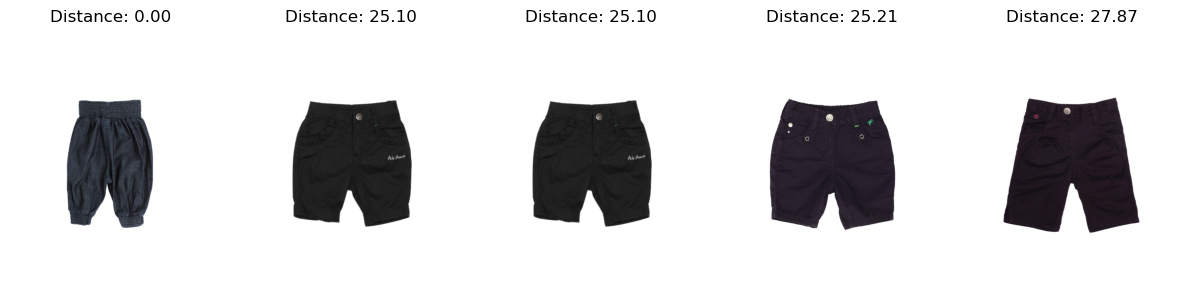

In [3]:
import os
import numpy as np
import joblib
import cv2
import time
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from tkinter import Tk, filedialog

# Step 1: Load Saved Models
# ============================================
# The pre-trained models (scaler, PCA, and k-NN) are loaded for reuse.
scaler = joblib.load("scaler.pkl")  # StandardScaler model for standardizing features
pca = joblib.load("pca.pkl")        # PCA model for dimensionality reduction
lsh_model = joblib.load("lsh_model.pkl")  # k-Nearest Neighbors model for similarity search

# Step 2: Load Pre-trained ResNet50 Model
# ============================================
# ResNet50 is used for feature extraction. The classification layers are removed, 
# and the output of the global average pooling ('avg_pool') layer is used.
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)


# Step 3: Feature Extraction Function
# ============================================
# This function extracts feature vectors from images using the ResNet50 model.
def extract_features(img_path):
    """
    Extracts a feature vector from an image using ResNet50.

    Parameters:
        img_path (str): Path to the input image.

    Returns:
        np.ndarray: Flattened feature vector of the image.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_data = image.img_to_array(img)  # Convert to NumPy array
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # Preprocess for ResNet50

    # Extract features and return as a flattened vector
    features = model.predict(img_data)
    return features.flatten()


# Step 4: Display Similar Images
# ============================================
# This function visualizes the similar images retrieved based on their indices.
def display_similar_images(indices, distances, data_directory, image_paths):
    """
    Displays the similar images along with their similarity distances.

    Parameters:
        indices (list): List of indices of the similar images.
        distances (list): List of distances corresponding to the indices.
        data_directory (str): Directory containing the image dataset.
        image_paths (list): List of all image paths in the dataset.
    """
    plt.figure(figsize=(15, 5))  # Define figure size for the display
    for i, (index, distance) in enumerate(zip(indices, distances)):
        # Get the image path using the index
        img_path = image_paths[index]
        
        # Load and preprocess the image for visualization
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib

        # Display the image with its distance
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.title(f"Distance: {distance:.2f}")
        plt.axis('off')
    plt.show()


# Step 5: Query Image Processing
# ============================================
# This function processes a query image, extracts its features, finds similar images, and displays them.
def process_query_image(k=5, data_directory="path_to_images"):
    """
    Processes a query image to find and display similar images.

    Parameters:
        k (int): Number of similar images to retrieve.
        data_directory (str): Path to the directory containing the image dataset.
    """
    # Open a file dialog to select the query image
    Tk().withdraw()  # Hide the root Tkinter window
    query_img_path = filedialog.askopenfilename(
        title="Select Query Image",
        filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")]
    )

    # Handle the case where no file is selected
    if not query_img_path:
        print("No file selected.")
        return

    # Get all image paths in the dataset
    image_paths = [os.path.join(data_directory, fname) for fname in os.listdir(data_directory) if fname.endswith('.jpg')]

    # Start timing the process
    start_time = time.time()

    # Step 1: Extract features from the query image
    query_features = extract_features(query_img_path)
    query_features_scaled = scaler.transform([query_features])  # Standardize features
    query_features_reduced = pca.transform(query_features_scaled)  # Reduce dimensions with PCA

    # Step 2: Find the nearest neighbors using the k-NN model
    distances, indices = lsh_model.kneighbors(query_features_reduced, n_neighbors=k)

    # Measure total processing time
    total_time = time.time() - start_time
    print(f"Query processed in {total_time:.4f} seconds")

    # Step 3: Display the similar images
    display_similar_images(indices[0], distances[0], data_directory, image_paths)


# Step 6: Example Usage
# ============================================
# Define the path to the image dataset and invoke the query processing function.

data_directory = "C:\\Users\\hp\\Downloads\\archive (5)\\data\\Apparel\\Girls\\Images\\images_with_product_ids"  # Replace with your dataset path
process_query_image(k=5, data_directory=data_directory)


Extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━

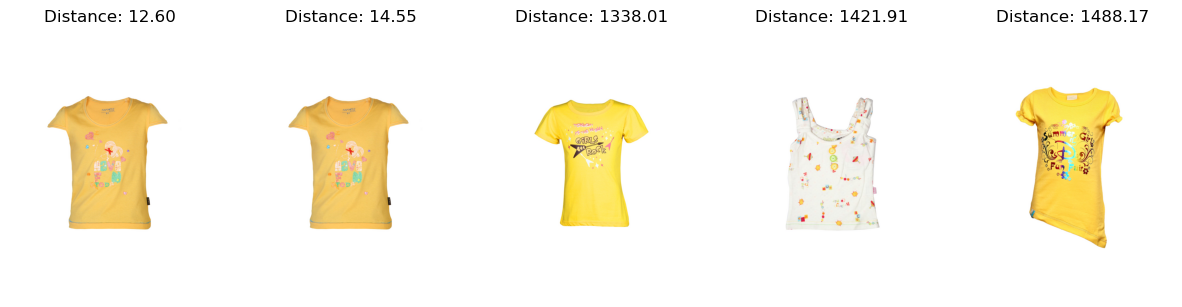

In [4]:
import numpy as np
import faiss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import os
from tkinter import filedialog, Tk
import matplotlib.pyplot as plt
import cv2

# Step 1: Load Pre-trained ResNet50 Model
# ========================================
# ResNet50 is used for feature extraction. The model's classification layers are removed,
# and the output of the global average pooling layer ("avg_pool") is used.
base_model = ResNet50(weights="imagenet")
model = Model(inputs=base_model.input, outputs=base_model.get_layer("avg_pool").output)

# Step 2: Feature Extraction
# ========================================
def extract_features(img_path):
    """
    Extracts feature vectors from an image using the ResNet50 model.

    Parameters:
        img_path (str): Path to the input image.

    Returns:
        np.ndarray: Flattened feature vector.
    """
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to 224x224
    img_data = image.img_to_array(img)  # Convert to NumPy array
    img_data = np.expand_dims(img_data, axis=0)  # Add batch dimension
    img_data = preprocess_input(img_data)  # Preprocess for ResNet50
    features = model.predict(img_data)  # Extract features
    return features.flatten()

# Step 3: Build Product Quantization (PQ) Index
# ========================================
def build_pq_index(features, num_subspaces, subspace_dimension):
    """
    Builds a Product Quantization (PQ) index using FAISS.

    Parameters:
        features (np.ndarray): Matrix of feature vectors.
        num_subspaces (int): Number of subspaces for PQ.
        subspace_dimension (int): Dimension of each subspace.

    Returns:
        faiss.IndexPQ: Trained PQ index.
    """
    d = features.shape[1]  # Feature dimensionality
    assert d % (num_subspaces * subspace_dimension) == 0, \
        "Feature dimension must be divisible by num_subspaces * subspace_dimension"

    # Create and train the PQ index
    quantizer = faiss.IndexFlatL2(d)  # Base quantizer
    pq_index = faiss.IndexPQ(d, num_subspaces, subspace_dimension)
    pq_index.train(features)
    pq_index.add(features)  # Add features to the index
    return pq_index

# Step 4: Search PQ Index
# ========================================
def search_pq_index(pq_index, query_feature, k=5):
    """
    Searches for similar images in the PQ index.

    Parameters:
        pq_index (faiss.IndexPQ): Trained PQ index.
        query_feature (np.ndarray): Feature vector of the query image.
        k (int): Number of nearest neighbors to retrieve.

    Returns:
        (list, list): Indices and distances of the top-k similar images.
    """
    distances, indices = pq_index.search(query_feature, k)
    return indices[0], distances[0]

# Step 5: GUI to Select Query Image
# ========================================
def select_query_image():
    """
    Opens a file dialog to select a query image.

    Returns:
        str: Path to the selected image.
    """
    root = Tk()
    root.withdraw()  # Hide the root Tkinter window
    file_path = filedialog.askopenfilename(title="Select Query Image")
    return file_path

# Step 6: Display Similar Images
# ========================================
def display_similar_images(indices, distances, data_directory, filenames):
    """
    Displays the similar images along with their similarity distances.

    Parameters:
        indices (list): List of indices of similar images.
        distances (list): List of distances corresponding to the indices.
        data_directory (str): Path to the dataset directory.
        filenames (list): List of image filenames in the dataset.
    """
    plt.figure(figsize=(15, 5))  # Define figure size for the display
    for i, (index, distance) in enumerate(zip(indices, distances)):
        if index < len(filenames):
            img_path = os.path.join(data_directory, filenames[index])
        else:
            print(f"Warning: Index {index} out of range for filenames.")
            continue
        img = cv2.imread(img_path)  # Load the image
        if img is None:
            print(f"Warning: Could not load image at path {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
        plt.subplot(1, len(indices), i + 1)
        plt.imshow(img)
        plt.title(f"Distance: {distance:.2f}")
        plt.axis("off")
    plt.show()

# Step 7: Main Function
# ========================================
def main():
    """
    Main function to extract features, build the PQ index, and process a query image.
    """
    data_directory = "C:\\Users\\hp\\Downloads\\archive (5)\\data\\Apparel\\Girls\\Images\\images_with_product_ids"  # Path to dataset
    filenames = sorted([f for f in os.listdir(data_directory) if f.endswith('.jpg')])

    # Step 1: Extract features for all images
    print("Extracting features...")
    all_features = np.array([extract_features(os.path.join(data_directory, f)) for f in filenames])

    # Step 2: Standardize features
    scaler = StandardScaler()
    all_features_scaled = scaler.fit_transform(all_features)

    # Step 3: Reduce dimensionality using PCA
    pca = PCA(n_components=64)  # Reduce to 64 dimensions
    all_features_reduced = pca.fit_transform(all_features_scaled)

    # Step 4: Build PQ index
    print("Building PQ index...")
    num_subspaces = 8
    subspace_dimension = 8  # 8 * 8 = 64
    pq_index = build_pq_index(all_features_reduced, num_subspaces, subspace_dimension)

    # Step 5: Select a query image
    query_image_path = select_query_image()
    print("Processing query image...")
    query_feature = extract_features(query_image_path)
    query_feature_scaled = scaler.transform([query_feature])
    query_feature_reduced = pca.transform(query_feature_scaled)

    # Step 6: Search PQ index for similar images
    print("Searching for similar images...")
    indices, distances = search_pq_index(pq_index, query_feature_reduced, k=5)

    # Step 7: Display similar images
    display_similar_images(indices, distances, data_directory, filenames)

# Entry Point
if __name__ == "__main__":
    main()
